Selected Observatory: Cerro, Latitude: -30.1692 degrees


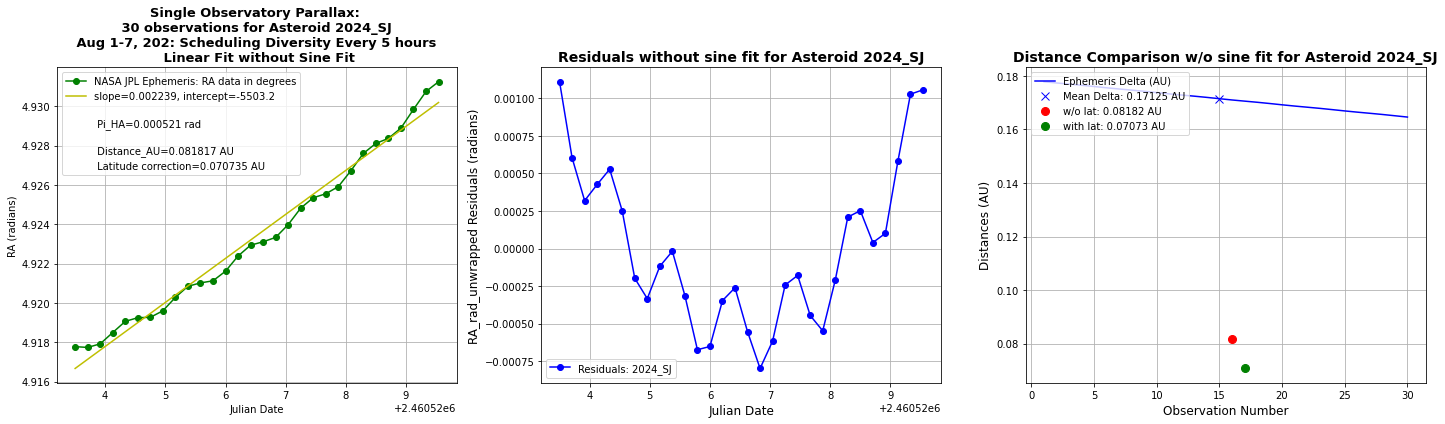

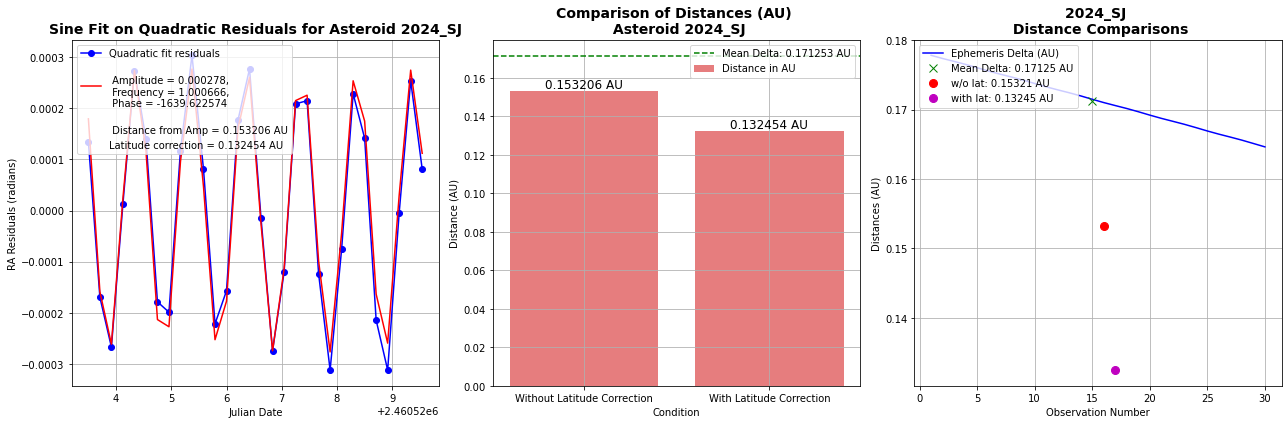

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.time import Time
import re
from astropy.coordinates import EarthLocation, AltAz
from astropy.coordinates import get_sun
from astropy.modeling import models, fitting
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

#--------------------------------------------------------------------------------------
# Load data and extract asteroid name
file_path = '01.1) Cerro_2024_SJ_Diversity.xlsx' ####################################
horizons_data = pd.read_excel(file_path)
asteroid_name = re.search(r'_(\d{4}_[A-Z]+)', file_path).group(1)

#--------------------------------------------------------------------------------------
AU_to_km = 149597870.7 
earth_radius_km = 6371

#--------------------------------------------------------------------------------------
# Dictionary to map observatory names to their latitudes
observatories = {
    'Cerro': -30.1692,            # Cerro Tololo Observatory
    'Castel_Gandolfo': 41.7412,   # Castel Gandolfo Observatory
    'Mt._Graham-VATT': 32.7016}    # Mt. Graham-VATT Observatory

# Extract observatory name from the file name and select the corresponding latitude
observatory_name = re.search(r'(Cerro|Castel_Gandolfo|Mt\._Graham-VATT)', file_path).group(1)
lat_observatory = observatories[observatory_name]

# Convert latitude to radians and compute cosine for latitude correction
theta_lat_rad = np.deg2rad(lat_observatory)
cos_theta_lat = np.cos(theta_lat_rad)

print(f"Selected Observatory: {observatory_name}, Latitude: {lat_observatory} degrees")
    
#--------------------------------------------------------------------------------------
# Function to convert RA from HMS to degrees
def hms_to_deg(hms_str):
    parts = re.split(r'\s+', hms_str.strip())
    h, m, s = [float(part) for part in parts]
    return 15 * (h + m/60 + s/3600) 

horizons_data.columns = horizons_data.columns.str.strip()
horizons_data['RA_deg'] = horizons_data['R.A._(ICRF)'].apply(hms_to_deg)
horizons_data['RA_rad'] = np.deg2rad(horizons_data['RA_deg'])
horizons_data['RA_rad_unwrapped'] = np.unwrap(horizons_data['RA_rad'])
columns_to_plot = ['RA_rad_unwrapped']

#fig, axs = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
#for i, column in enumerate(columns_to_plot):
#    axs.plot(horizons_data['Date__(UT)__HR:MN'], horizons_data[column], label=column)
#    axs.set_ylabel(column)
#    axs.grid(True)
#    axs.legend()
#axs.set_xlabel('Time') 
#plt.suptitle("Unwrapped RA of Asteroid {asteroid_name}", fontsize=16, y=1)
#plt.tight_layout()
#plt.show()

#--------------------------------------------------------------------------------------
# Convert observation times to Julian Day (JD)
horizons_data['Date__(UT)__HR:MN'] = pd.to_datetime(horizons_data['Date__(UT)__HR:MN'], format='%Y-%b-%d %H:%M')
observation_times = Time(horizons_data['Date__(UT)__HR:MN'], scale='utc')
horizons_data['observation_times'] = observation_times
t_jd = observation_times.jd  
horizons_data['t_jd'] = t_jd
N_obs_all = len(t_jd)

horizons_data['delta_km'] = horizons_data['delta'] * AU_to_km
#print(horizons_data[['Date__(UT)__HR:MN', 't_jd', 'delta', 'delta_km']])

#--------------------------------------------------------------------------------------
# Fit a linear model to RA data
linear_model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()  
fitted_model = fitter(linear_model, t_jd, horizons_data['RA_rad_unwrapped'])  

slope = fitted_model.slope.value
intercept = fitted_model.intercept.value
RA_predicted = fitted_model(t_jd)

# Compute residuals
residuals = horizons_data['RA_rad_unwrapped'] - RA_predicted
residuals_squared = residuals ** 2
sum_squared_residuals = np.sum(residuals_squared)
mean_squared_residuals = sum_squared_residuals / N_obs_all
Pi_HA = np.sqrt(mean_squared_residuals) 

# Distance computations
Distance = earth_radius_km/Pi_HA
Distance_AU = Distance / AU_to_km

# Latitude correction
Distance_lat = cos_theta_lat * Distance
Distance_AU_lat = Distance_lat / AU_to_km

#--------------------------------------------------------------------------------------
# Create subplots for RA data, residuals, and distance comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot RA data and predictions
ax1.plot(t_jd,  horizons_data['RA_rad_unwrapped'], 'go-', label='NASA JPL Ephemeris: RA data in degrees')
ax1.plot(t_jd, RA_predicted, 'y-', label=f'slope={slope:.6f}, intercept={intercept:.1f}')

ax1.plot([], [], ' ', label=f'\n Pi_HA={Pi_HA:.6f} rad')
ax1.plot([], [], ' ', label=f'\n Distance_AU={Distance_AU:.6f} AU')
ax1.plot([], [], ' ', label=f' Latitude correction={Distance_AU_lat:.6f} AU')

ax1.set_xlabel('Julian Date')
ax1.set_ylabel('RA (radians)')
bold_font = FontProperties(weight='bold')
ax1.set_title(f"Single Observatory Parallax: \n {N_obs_all} observations for Asteroid {asteroid_name} \n Aug 1-7, 202: Scheduling Diversity Every 5 hours \n Linear Fit without Sine Fit", fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True)

#--------------------------------------------------------------------------------------
# Plot residuals
ax2.plot(t_jd, residuals, 'bo-', label=f'Residuals: {asteroid_name}')
ax2.set_xlabel('Julian Date', fontsize=12)
ax2.set_ylabel('RA_rad_unwrapped Residuals (radians)', fontsize=12)
ax2.set_title(f"Residuals without sine fit for Asteroid {asteroid_name}", fontsize=14, fontweight='bold')
ax2.grid(True)
ax2.legend()

#--------------------------------------------------------------------------------------
# Plot distance comparisons
mean_delta = horizons_data['delta'].mean()

delta_values = horizons_data['delta'].values
ax3.plot(range(1, len(delta_values) + 1), delta_values, 'b-', label='Ephemeris Delta (AU)')
ax3.plot(len(delta_values) // 2, mean_delta, 'bx', label=f'Mean Delta: {mean_delta:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 1, Distance_AU, 'ro', label=f'w/o lat: {Distance_AU:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 2, Distance_AU_lat, 'go', label=f'with lat: {Distance_AU_lat:.5f} AU', markersize=8)
ax3.set_xlabel('Observation Number', fontsize=12)
ax3.set_ylabel('Distances (AU)', fontsize=12)
ax3.set_title(f"Distance Comparison w/o sine fit for Asteroid {asteroid_name}", fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------
# Subtract quadratic fit and compute sine fit on residuals
t_jd_normalized = t_jd - np.mean(t_jd)
quadratic_model = models.Polynomial1D(degree=2)  
fitter = fitting.LinearLSQFitter()  
fitted_quadratic = fitter(quadratic_model, t_jd_normalized, horizons_data['RA_rad_unwrapped'])  
RA_quadratic_predicted = fitted_quadratic(t_jd_normalized)
residuals_after_quadratic = horizons_data['RA_rad_unwrapped'] - RA_quadratic_predicted

#--------------------------------------------------------------------------------------
# Fit sine model on quadratic residuals
sine_model = models.Sine1D(amplitude=0.05, frequency=1.0, phase=0.0) 
fitter_sine = fitting.LevMarLSQFitter()
fitted_sine = fitter_sine(sine_model, t_jd, residuals_after_quadratic)
sine_predicted = fitted_sine(t_jd)

#--------------------------------------------------------------------------------------
# Final distance comparison using sine fit
amplitude_radians = abs(fitted_sine.amplitude.value)

distance_km_amplitude = earth_radius_km / amplitude_radians
distance_au_amplitude = distance_km_amplitude / AU_to_km

Distance_km_lat_corrected_amplitude = cos_theta_lat * distance_km_amplitude
Distance_AU_lat_corrected_amplitude = Distance_km_lat_corrected_amplitude / AU_to_km

#--------------------------------------------------------------------------------------
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Sine Fit on residuals after subtracting quadratic fit
ax1.plot(t_jd, residuals_after_quadratic, 'bo-', label='Quadratic fit residuals')
ax1.plot(t_jd, sine_predicted, 'r-', label=(
    f'\n Amplitude = {fitted_sine.amplitude.value:.6f}, 'f'\n Frequency = {fitted_sine.frequency.value:.6f}, 'f'\n Phase = {fitted_sine.phase.value:.6f}'))

ax1.plot([], [], ' ', label=f'\n Distance from Amp = {distance_au_amplitude:.6f} AU')
ax1.plot([], [], ' ', label=f'Latitude correction = {Distance_AU_lat_corrected_amplitude:.6f} AU')

ax1.set_xlabel('Julian Date')
ax1.set_ylabel('RA Residuals (radians)')
ax1.set_title(f"Sine Fit on Quadratic Residuals for Asteroid {asteroid_name}", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True)

#--------------------------------------------------------------------------------------
# Subplot 2: Final distance comparison using sine amplitude fit
bars = ax2.bar(['Without Latitude Correction', 'With Latitude Correction'], distances_au, 
               color='tab:red', alpha=0.6, label='Distance in AU')

for bar, distance1 in zip(bars, distances_au):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{distance1:.6f} AU', ha='center', va='bottom', fontsize=12)

ax2.axhline(mean_delta, color='green', linestyle='--', label=f'Mean Delta: {mean_delta:.6f} AU')
ax2.set_xlabel('Condition')
ax2.set_ylabel('Distance (AU)')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_title(f'Comparison of Distances (AU) \n Asteroid {asteroid_name}', fontsize=14, fontweight='bold')
ax2.grid(True)

#--------------------------------------------------------------------------------------
# Subplot 3: Another plot comparison for delta values with and without latitude corrections
ax3.plot(range(1, len(delta_values) + 1), delta_values, 'b-', label='Ephemeris Delta (AU)')
ax3.plot(len(delta_values) // 2, mean_delta, 'gx', label=f'Mean Delta: {mean_delta:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 1, distance_au_amplitude, 'ro', label=f'w/o lat: {distance_au_amplitude:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 2, Distance_AU_lat_corrected_amplitude, 'mo', label=f'with lat: {Distance_AU_lat_corrected_amplitude:.5f} AU', markersize=8)

ax3.set_xlabel('Observation Number')
ax3.set_ylabel('Distances (AU)')
ax3.set_title(f"{asteroid_name} \n Distance Comparisons", fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True)

plt.subplots_adjust(wspace=0.4)  
plt.tight_layout()
plt.show()
